# Machine Learning 2021-II 
## Laboratorio 2: Regresión Lineal (Regularización/Regresión Bayesiana/SGD)

In [26]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from ipywidgets import interactive
from sklearn.linear_model import LinearRegression


### Funciones para graficar:

In [27]:
def plot_gd(X_train,t_train,y_train,X_test,t_test,y_test,w,log):

  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.scatter(X_train, t_train,  color='blue',label='Training samples')
  plt.plot(X_test, t_test,  color='green',label='Ideal (test) signal')
  plt.plot(X_test, y_test,  color='red',label='Predicted signal')
  plt.xlabel('Input variable')
  plt.ylabel('Output variable')
  plt.title('Training MSE {}'.format(log[-1]))
  plt.ylim([-3,3])
  plt.grid()
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(log)
  plt.xlabel('Epochs')
  plt.ylabel('Cost function')
  plt.show()

def plot_reg(X_train,t_train,y_train,X_test,t_test,y_test,mu,w):

  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.scatter(X_train, t_train,  color='blue',label='Training samples')
  plt.plot(X_test, t_test,  color='green',label='Ideal (test) signal')
  plt.plot(X_test, y_test,  color='red',label='Predicted signal')
  plt.xlabel('Input variable')
  plt.ylabel('Output variable')
  plt.ylim([-3,3])
  plt.grid()
  plt.legend()

  plt.subplot(1,2,2)
  plt.stem(mu.reshape(-1,),w.reshape(-1,))
  plt.xlabel('Centroid')
  plt.ylabel('Weight')
  plt.show()

def plot_bayes(X_train,t_train,y_train,X_test,t_test,y_bayes,std_bayes):
  
  plt.scatter(X_train, t_train,  color='blue',label='Training samples')
  plt.plot(X_test, t_test,  color='green',label='Clean signal')
  plt.plot(X_test.reshape(-1,), y_bayes, color='blue',label='Bayesian regression')
  plt.fill_between(X_test.reshape(-1,), y_bayes.ravel()+std_bayes.ravel(), y_bayes.ravel()-std_bayes.ravel(), color='blue', alpha=0.2,label='Bayesian regression')
  plt.xlabel('Input variable')
  plt.ylabel('Output variable')
  plt.ylim([-3,3])
  plt.grid()
  plt.legend()
  plt.show()

def plot_bayes_log(log):
  plt.figure(figsize=[15,5])
  plt.subplot(1,3,1)
  plt.plot(log['alpha'])
  plt.xlabel('Epochs')
  plt.ylabel('alpha')
  plt.subplot(1,3,2)
  plt.plot(log['beta'])
  plt.xlabel('Epochs')
  plt.ylabel('beta')
  plt.subplot(1,3,3)
  plt.plot(log['loss'])
  plt.xlabel('Epochs')
  plt.ylabel('MSE')
  plt.show()

### Generación de datos
El siguiente bloque define un sistema con ruido. El parámetro sigma controla el nivel ruido. El sistema entrega la salida con ruido y sin ruido en ese orden.

In [28]:
def sistema(x,sigma=0.2):
  a = 2
  y = a*np.sin(2*np.pi*x)
  #y = a*x**3 + b*x**2 + c*x + d
  e = sigma*np.random.randn(y.shape[0],y.shape[1])
  t = y + e
  return t,y


### **A.** La siguiente función define las funciones base RBF para un problema de regresión. 

* Defina un arreglo de `20` centroides `mu` espaciados linealmente entre `0` y `1`, y un ancho de banda del kernel Gaussiano de $\sigma=0.5$.

* Retorne la transformación de los datos $X$ como: $\phi_m(x)=\exp\left(-\frac{||x-\mu_m||^2}{2\sigma^2}\right)$



In [29]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel

mu = np.linspace(0, 1, 20).reshape(-1, 1)

def rbf(X):
  
  sigma = 0.5
  gamma = 1/(2*sigma**2)
  #Phi = np.random.rand(X.shape[0],mu.shape[0])
  return rbf_kernel(X, mu, gamma)

### **B.** En el siguiente bloque se crea la base de datos con `X_train` y `t_train` como entradas y salidas esperadas de entrenamiento del modelo.

* Entrene un regresor lineal usando las funciones base del literal **A**.

* Guarde las predicciones para el conjunto `Phi_train` en `y_train`. 

* Guarde las predicciones para el conjunto `Phi_test` en `y_test`. 

* Guarde los coeficientes del modelo lineal en la variable `w` para graficarlos.



Number of training samples: 10
(10, 1) (10, 1)
Number of test samples: 1000
(1000, 1) (1000, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


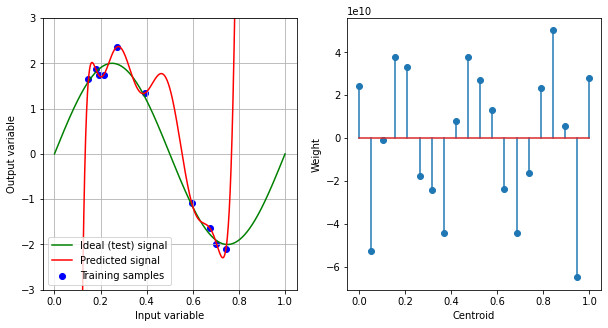

In [30]:
N = 10 # número de muestras a generar
x_init = 0
x_end = 1
X_train = np.random.uniform(x_init,x_end,(N,1))        
X_test  = np.linspace(x_init,x_end,1000).reshape(-1,1)

t_train,_ = sistema(X_train)
print('Number of training samples:',t_train.shape[0])
print(X_train.shape,t_train.shape)

_,t_test = sistema(X_test)
print('Number of test samples:',t_test.shape[0])
print(X_test.shape,t_test.shape)

####Ponga su código acá#######
transf = FunctionTransformer(rbf)

Phi_train = transf.transform(X_train)
Phi_test = transf.transform(X_test)

mol = LinearRegression().fit(Phi_train, t_train)
y_test = mol.predict(Phi_test)
y_train = mol.predict(Phi_train)
w = mol.coef_

#############################
plot_reg(X_train,t_train,y_train,X_test,t_test,y_test,mu,w)

### **C**. En el siguiente bloque se grafican los valores propios de la matriz $\Phi^\top\Phi + \alpha I_M$.

* Calcule la matriz $\Phi^\top\Phi + \alpha I_M$ usando `Phi_train` y guárdela en `C_reg`. Para la idéntica ver `numpy.eye`

* Calcule los valores propios de la matriz `C_reg` (ver `numpy.linalg.eigvals`) y guárdelos en `eigvals_C`

* Idenfique el efecto de aumentar el valor de la regularización $\alpha$

In [31]:
def plot_alpha(power):

  alpha = 10**power
  C_reg = Phi_train.T@Phi_train + alpha*np.eye(len(Phi_train.T@Phi_train))

  eigvals_C = np.linalg.eigvals(C_reg)

  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.stem(eigvals_C)
  plt.title('Regularization factor {}'.format(alpha))
  plt.ylabel('Eigenvalue')

  plt.subplot(1,2,2)
  plt.imshow(C_reg)
  plt.colorbar()
  plt.title('Matrix $\Phi^T\Phi + aI_M$')
  #plt.ylabel('Eigenvalue')

  plt.show()

interactive_plot = interactive(plot_alpha, power=(-3,3,0.1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='power', max=3.0, min=-3.0), Output(layout=Layout(hei…

### **D**. En el siguiente bloque se crea el regresor lineal con regularización norma-2. 

* En la función `ridge_fit` reemplace el valor de `w` por la solución de norma-2: $w=(\Phi^\top\Phi+\alpha I_M)\Phi^\top t$

* En la función `linear_predict` reemplace el valor de `y` por el modelo de regresión lineal: $y=\Phi w$

* Identifique el efecto de $\alpha$ en la regresión y escoja el que crea mejor.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


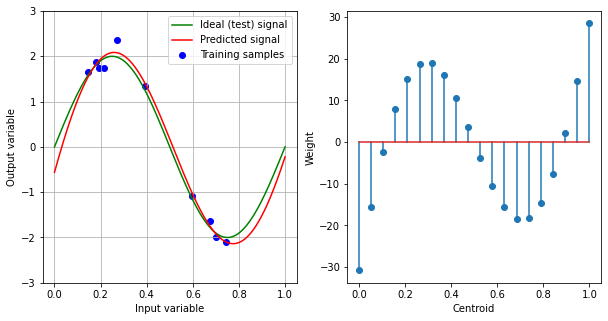

In [32]:
def ridge_fit(Phi,t,alpha):
  w = np.linalg.inv(Phi.T@Phi + alpha*np.identity(Phi.shape[1]))@Phi.T@t #np.eye(len(Phi_train.T@Phi_train))
  return w

def linear_predict(Phi,w):
  y = Phi@w
  return y

w_manual = ridge_fit(Phi_train,t_train,5e-6)
y_manual = linear_predict(Phi_test,w_manual)

plot_reg(X_train,t_train,y_train,X_test,t_test,y_manual,mu,w_manual)

### **E.** Repita el literal **B** empleando el regresor lineal con regularización de norma 2 (`sklearn.linear_model.Ridge`)

* Guarde el resultado de la predicción sobre `Phi_test` en `y_ridge`.

* Emplee diferentes valores para el coeficiente de regularización. 

* Identifique el efecto de `alpha` en el resultado de la regularización

NOTA: Tenga cuidado con la escala de los valores de `w`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


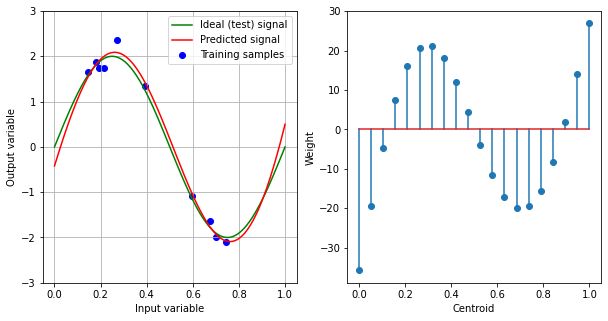

In [33]:
####Ponga su código acá#######
from sklearn.linear_model import Ridge

clf = Ridge(alpha=1e-6)
clf.fit(Phi_train, t_train)

y_ridge = clf.predict(Phi_test)
w_ridge = clf.coef_
##############################
plot_reg(X_train,t_train,y_train,X_test,t_test,y_ridge,mu,w_ridge)


### **F.** Repita el literal **B** empleando el regresor lineal con regularización de norma 1 (`sklearn.linear_model.Lasso`)

* Guarde el resultado de la predicción sobre `Phi_test` en `y_lasso`.

* Emplee diferentes valores para el coeficiente de regularización. 

* Identifique el efecto de `alpha` en el resultado de la regularización

NOTA: Tenga cuidado con la escala de los valores de `w`

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34652032499748997, tolerance: 0.003040967114093722
  positive)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


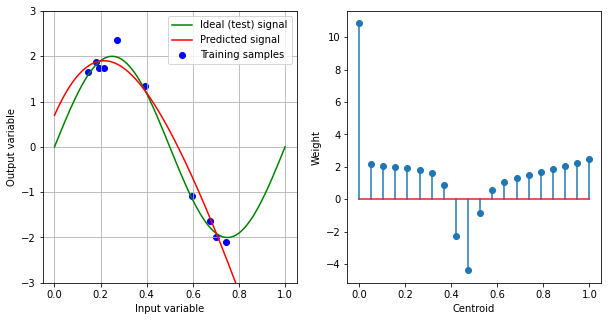

In [34]:
####Ponga su código acá#######
from sklearn.linear_model import Lasso

clf = Lasso(alpha=1e-24) #-12
clf.fit(Phi_train, t_train)

y_lasso = clf.predict(Phi_test)
w_lasso = clf.coef_

##############################
plot_reg(X_train,t_train,y_train,X_test,t_test,y_lasso,mu,w_lasso)

### **G.** En el siguiente bloque se emula el caso en el que las muestras llegan de forma secuencial.

* Aplique las funciones base RBF a `X_train` para generar `Phi_train`.

* En la función `bayes_update` implemente las ecuaciones del posterior de los pesos:

$S^{-1}_N=\alpha I_M + \beta \Phi^\top\Phi$

$m_N=\beta S_N \Phi^\top t$

* En la función `bayes_predict` implemente las ecuaciones de la distribución predictiva (media y varianza) y guárdelas en `y_mean` y `y_var`, respectivamente:

$\mu_t = \Phi m_N$

$\sigma^2_t = \frac{1}{\beta} + \text{diag}(\Phi S_N\Phi^\top)$

* Use el slider para incrementar el número de muestras consideradas en el entrenamiento.

* Emplee diferentes valores para los parámetros  `alpha` y `beta`.

* Identifique el efecto agregar muestras en la predicción.

* Identifique el efecto de los hiperparámetros `alpha` y `beta` en el resultado de la predicción.

* Escoja un par de valores `alpha` y `beta` que considere apropiados para la predicción.

In [35]:
X_train = np.random.uniform(x_init,x_end,(100,1))
t_train,_ = sistema(X_train)

#Calcule Phi_train
Phi_train = transf.transform(X_train)

def bayes_update(Phi,t,alpha,beta):
  
  #Calcule SNinv
  SNinv = (alpha*np.identity(Phi.shape[1]))+(beta*np.transpose(Phi)@Phi)  #(alpha*np.eye(Phi.shape[1]))@(beta*np.transpose(Phi)@Phi)
  #Calcule SN
  SN = np.linalg.inv(SNinv)
  #Calcule mN
  mN = beta*SN@np.transpose(Phi)@t

  return mN,SN

def bayes_predict(Phi,mN,SN,alpha,beta,return_std=True):

  #Calcule y_mean
  y_mean = Phi@mN
  #Calcule y_var
  y_var = (1/beta)+np.diag(Phi@SN@np.transpose(Phi))

  if return_std:
    return y_mean,np.sqrt(y_var).reshape(-1,1)
  else:
    return y_mean

def myfun(N=1):

  beta = 2
  alpha = 0.5
  mN,SN = bayes_update(Phi_train[:N,:],t_train[:N,:],alpha,beta)

  y_bayes,std_bayes = bayes_predict(Phi_test,mN,SN,alpha,beta)

  plot_bayes(X_train[:N,:],t_train[:N,:],y_train[:N,:],X_test,t_test,y_bayes,std_bayes)

interactive_plot = interactive(myfun, N=(1,100))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=1, description='N', min=1), Output(layout=Layout(height='350px'))), _dom…

**H.** Aproximación de la evidencia

* En la función `gamma_update` implemente la ecuación para la ajuste del parámetro $\gamma$:

    $\gamma=\sum_i{\frac{\lambda_i}{\lambda_i+\alpha}}$

    $\lambda = eig(\beta\Phi^\top\Phi)$

* En la función `alpha_update` implemente la ecuación de actualización del prior $\alpha$:

    $\alpha=\frac{\gamma}{\mathbf{m}_N^\top\mathbf{m}_N}$

* En la función `beta_update` implemente la ecuación de actualización de la precisión del ruido $\beta$:

    $\beta^{-1}=\frac{1}{N-\gamma}(\mathbf{t}-\mathbf{y})^\top(\mathbf{t}-\mathbf{y})$


* En la función `loss` implemente la ecuación de la función de costo MSE:

    $loss=(\mathbf{t}-\mathbf{y})^\top(\mathbf{t}-\mathbf{y})$


In [36]:
def gamma_update(Phi,alpha,beta):

  #Calcule gamma
  eig_vals = np.linalg.eigvals(beta*np.transpose(Phi)@Phi) #beta*Phi.T
  gamma = 0
  for eig_val in eig_vals:
    gamma += eig_val / (eig_val + alpha)
  return np.real(gamma)

def alpha_update(gamma,mN):

  #Calcule alpha
  N = mN.T@mN
  alpha = gamma / N
  return alpha

def beta_update(gamma,t,y):
  
  #Calcule beta_inv
  delta_ty = t - y
  beta_inv = 1 / (t.shape[0] - gamma) * (delta_ty.T@delta_ty)
  return 1/beta_inv

def loss(t,y):
  
  #Calcule el error cuadrático medio
  delta_ty = t - y
  mse = delta_ty.T@delta_ty
  return mse.ravel()

#La siguiente función hace el entrenamiento del modelo bayesiano empleando las 
# funciones implementadas. No la cambie xfv
def bayes_fit(Phi,t,alpha_0,beta_0,maxiter=10):
  alpha = alpha_0
  beta = beta_0
  alpha_log = []
  beta_log = []
  loss_log = []
  for iter in range(maxiter):
    
    #Update the posterior.
    mN, SN = bayes_update(Phi,t,alpha,beta)
    
    #Evaluate the model
    y = bayes_predict(Phi,mN,SN,alpha,beta,return_std=False)

    #Log results
    alpha_log.append(alpha)
    beta_log.append(beta)
    loss_log.append(loss(t,y))
 
    #Update according the evidence
    gamma = gamma_update(Phi,alpha,beta)
    alpha = alpha_update(gamma,mN)
    beta = beta_update(gamma,t,y) 
  
  return mN,SN,alpha,beta,{'alpha':alpha_log,'beta':beta_log,'loss':loss_log}

* Ejecute el siguiente bloque para evaluar su implementación

NOTA: Este modelo se encuentra implementado en `sklearn.linear_model.BayesianRidge` con aprendizaje de la varianza del ruido y del prior de los pesos como una densidad Gamma.

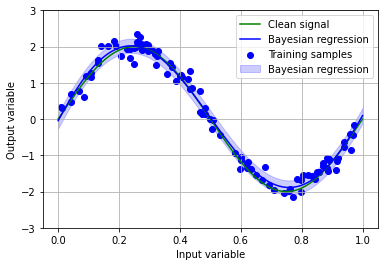

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


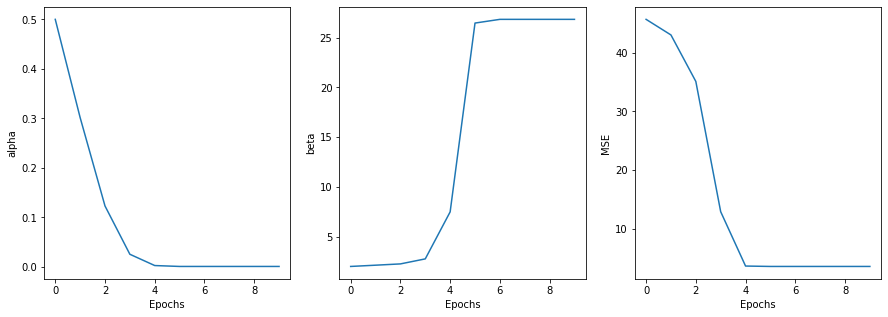

In [37]:

mN,SN,alpha,beta,log = bayes_fit(Phi_train,t_train,0.5,2,maxiter=10)

y_bayes,std_bayes = bayes_predict(Phi_test,mN,SN,alpha,beta)

plot_bayes(X_train,t_train,y_train,X_test,t_test,y_bayes,std_bayes)

plot_bayes_log(log)

**I.** Implemente las ecuaciones para el entrenamiento del modelo lineal por gradiente descente estocástico:

* En la función `gradient` implemente la ecuación de cálculo del gradiente:

  $\nabla J=-\Phi^\top\mathbf{e}$

  $\mathbf{e}=\mathbf{t}-\mathbf{y}$


* En la función `sgd_fit` complete el algoritmo de gradiente descendiente.

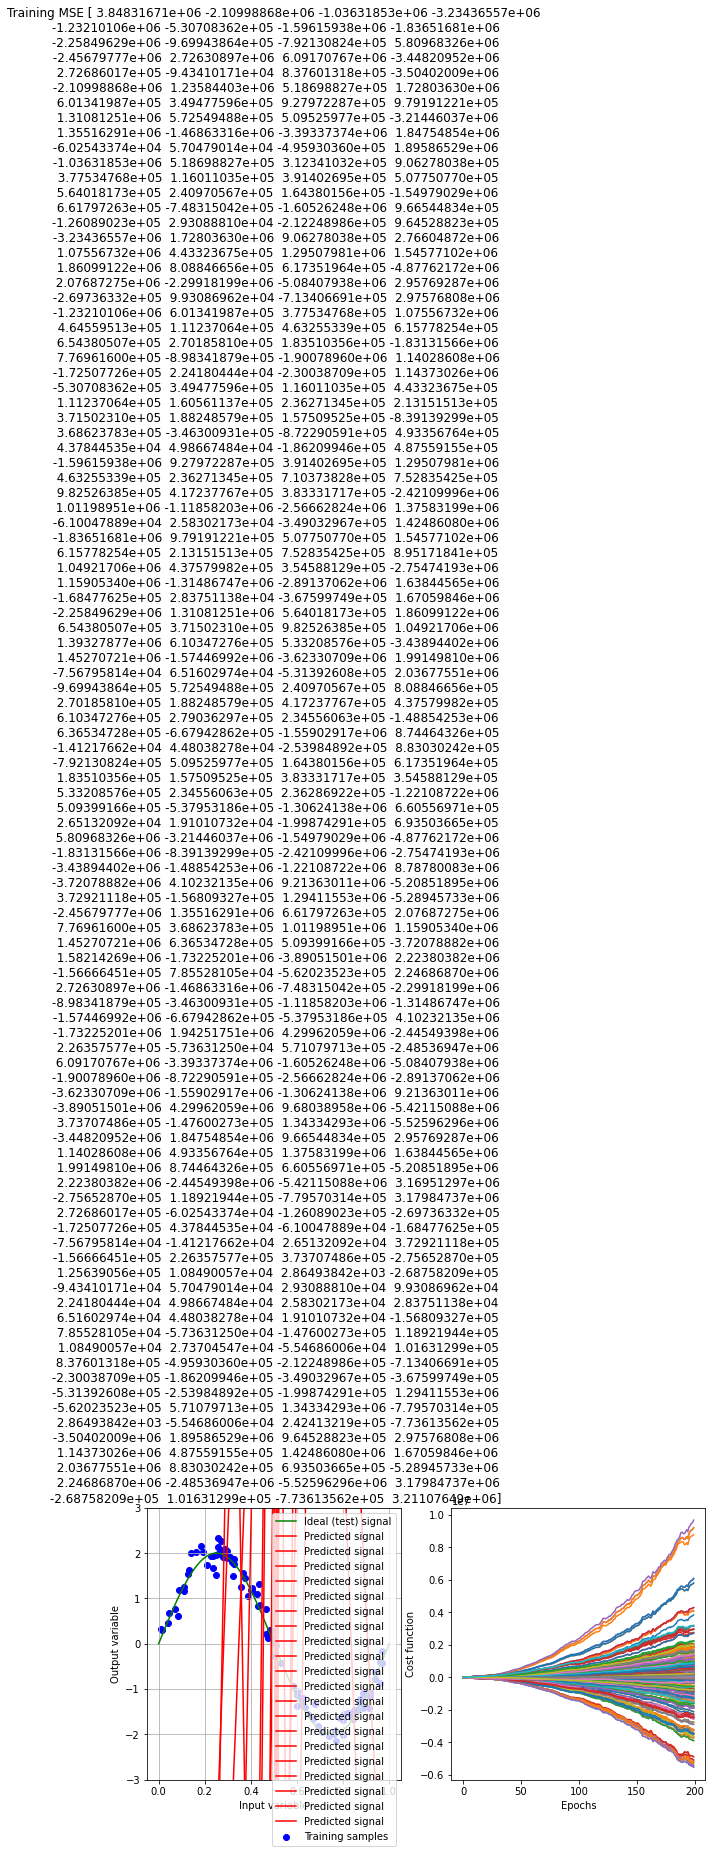

In [39]:
def gradient(Phi,t,y):
  
  #Calcule el gradiente
  e = t - y
  grad = -np.transpose(Phi)*e 
  return grad

def gd_fit(Phi,t,w0,lr,maxiter=100):

  #Step 1: Initalize and define learning rate. It's already done.
  w = w0.copy()
  log = []
  for iter in range(maxiter):

    #Complete el paso 2: Make predictions. Use your function linear_predict 
    # with Phi and w and save it into y
    y = linear_predict(Phi, w)

    #Complete el paso 3: Compute your the cost function. Use your function loss 
    # with t and y and save it in l
    l = loss(t, y)
    log.append(l)

    #Step 4: This is the teacher step for shuffling data. Don't change it plz
    index = np.arange(Phi.shape[0])
    np.random.shuffle(index)

    #Step 5: Compute the gradient with a subset of shuffled data. I did it for you guys ;)
    grad = gradient(Phi[index[:20]],t[index[:20]],y[index[:20]])

    #Completar el paso 6: Update the vector of coefficients w using the result 
    # of the gradient and the learning rate.
    w += w0 - lr*grad

  return w,log

w_gd,log = gd_fit(Phi_train,t_train,np.random.rand(20,20)*2-1,1e-2,200)

y_train = linear_predict(Phi_train,w_gd)

y_gd = linear_predict(Phi_test,w_gd)

plot_gd(X_train,t_train,y_train,X_test,t_test,y_gd,w_gd,log)


### **J.** Cargue los datos `california_housing_train` y `california_housing_test`. 

* Entrene un modelo de regresión lineal (Linear, Ridge, Lasso, o Bayesian, SGD) con las funciones bases que considere adecuadas (Ninguna o Polinomiales) que prediga la variable `median_house_value` a partir de las otras 8 variables. 

* Evalúe la calidad de su regresor usando los datos de test en términos del score y del scatter plot. 

In [40]:
import pandas as pd
import seaborn as sns

ch_train = pd.read_csv("/content/sample_data/california_housing_train.csv")
ch_test = pd.read_csv("/content/sample_data/california_housing_test.csv")

In [41]:
ch_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [42]:
X_train = ch_train[["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]]
y_train = ch_train["median_house_value"]

In [43]:
clf = Ridge(alpha=1e-6)
clf.fit(X_train, y_train)
print(clf.intercept_)

-3620600.892144562


In [44]:
X_test = ch_test[['longitude',	'latitude',	'housing_median_age',	'total_rooms',	'total_bedrooms',	'population',	'households',	'median_income']]
y_test = ch_test['median_house_value']

Text(0.5, 1.0, 'median_house_value')

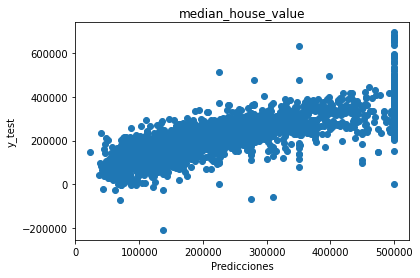

In [45]:
predictions = clf.predict(X_test)
plt.scatter(y_test,predictions)
plt.xlabel("Predicciones")
plt.ylabel("y_test")
plt.title("median_house_value")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


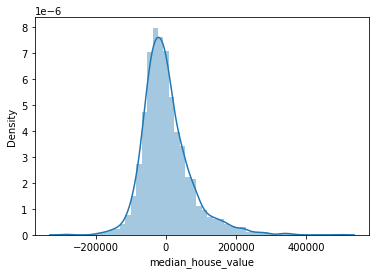

In [46]:
sns.distplot((y_test-predictions),bins=50);

In [47]:
from sklearn.metrics import accuracy_score

print(clf.score)
print()
print("Score:",clf.score(X_test, y_test))

<bound method RegressorMixin.score of Ridge(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)>

Score: 0.6195057678319964


*Como podemos observar, con el modelo escogido `RIDGE`, tenemos un score del 0.6195; en otras palabras, un modelo no muy acertado para la ocasión.*